This notebook includes:  
1. Feature engineering and ml with PySpark libs    
2. EDA with seaborn like pairplot, barplot, distplot, stripplot
3. EDA with pandas profiler

In [1]:
! pip install pyspark

     |████████████████████████████████| 217.8MB 162kB/s 
     |████████████████████████████████| 204kB 31.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218258789 sha256=4d72c6415c9ed542c233fe6db323ee40466b4c0883446ec08cd11ede5e140fad
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession, DataFrame, functions as F
from pyspark.ml.feature import Imputer, StringIndexer, VectorIndexer, VectorAssembler, OneHotEncoderEstimator, PCA, Bucketizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

import pandas as pd
import pandas_profiling
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [3]:
# For EDA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
spark = SparkSession.builder.appName("Titanic-Dataset").config('spark.driver.memory','15g').getOrCreate()
spark
# spark.stop()

***The ML Pipeline Steps***:
- [Data IO](#Data-IO)
- [Data Cleaning](#Data-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [ML Model](#ML-Model)


# Data IO

In [5]:
# sdf_train = spark.read.csv('/kaggle/input/titanic/train.csv', inferSchema = True, header = True)
# sdf_test = spark.read.csv('/kaggle/input/titanic/test.csv', inferSchema = True, header = True)
file_location = "/FileStore/tables/train.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# display(data)

# Data Cleaning

In [6]:
def _clean_dataset(sdf: DataFrame, col_to_convert: list, col_to_impute: list) -> DataFrame:
    for col in col_to_convert:
        sdf = sdf.withColumn(col,sdf[col].cast('double'))
    col_to_impute += col_to_convert

    imputer = Imputer(inputCols = col_to_impute, outputCols = col_to_impute)
    sdf = imputer.fit(sdf).transform(sdf)
    
    return sdf

# Feature Engineering

**With manually treating features :**

In [7]:
def _handle_missing_age(sdf: DataFrame) -> DataFrame:
    _sdf = sdf
    _sdf = _sdf.withColumn('Age', 
           F.when((F.isnull(_sdf['Age'])) & (_sdf['Initial'] == 'Mr') , 33 )\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Mrs') , 36)\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Master') , 5)\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Miss') , 22)\
            .otherwise(F.when((F.isnull(_sdf['Age'])) 
                              & (_sdf['Initial'] == 'Other') , 46)\
            .otherwise(_sdf['Age']) )))))
    return _sdf

In [8]:
def _evaluate_initials(sdf: DataFrame) -> DataFrame:
    dizip_initials = {k:v for k,v in (zip(['Mlle','Mme','Ms','Dr',
                                           'Major','Lady','Countess',
                                           'Jonkheer','Col','Rev',
                                           'Capt','Sir','Don'],
                                         ['Miss','Miss','Miss',
                                          'Mr','Mr','Mrs','Mrs',
                                          'Other','Other','Other',
                                          'Mr','Mr','Mr']))}
    _sdf = sdf.withColumn('Initial',  F.regexp_extract( sdf['Name'], ('([A-Za-z]+)\.'),1 ) )
    _sdf = _sdf.replace(dizip_initials,1,'Initial')
    return _sdf


In [9]:
def _create_family_size(sdf: DataFrame) -> DataFrame :
    _sdf = sdf.withColumn('FamilySize', sdf['Parch'] + sdf['SibSp'] + 1 )
    
    return _sdf


In [10]:
sdf_train_cleaned = _clean_dataset ( 
    _handle_missing_age(
    _evaluate_initials(
    _create_family_size(sdf_train)
    )) 
    ,['Ticket','SibSp','Parch'],['Fare'] 
)

sdf_test_cleaned = _clean_dataset ( 
    _handle_missing_age(
    _evaluate_initials(
    _create_family_size(sdf_test)
    )) 
    ,['Ticket','SibSp','Parch'],['Fare'] 
)

sdf_train_cleaned.limit(5).toPandas().T

/opt/conda/lib/python3.6/site-packages/pyspark/sql/dataframe.py:1800: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,260319,260319,260319,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [11]:
pdf_sdf_train = sdf_train_cleaned.toPandas()
pdf_sdf_train.T

,0,1,2,3,4,5,6,7,8,9,...,881,882,883,884,885,886,887,888,889,890
PassengerId,1,2,3,4,5,6,7,8,9,10,...,882,883,884,885,886,887,888,889,890,891
Survived,0,1,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
Pclass,3,1,3,1,3,3,1,3,3,2,...,3,3,2,3,3,2,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry","Moran, Mr. James","McCarthy, Mr. Timothy J","Palsson, Master. Gosta Leonard","Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)","Nasser, Mrs. Nicholas (Adele Achem)",...,"Markun, Mr. Johann","Dahlberg, Miss. Gerda Ulrika","Banfield, Mr. Frederick James","Sutehall, Mr. Henry Jr","Rice, Mrs. William (Margaret Norton)","Montvila, Rev. Juozas","Graham, Miss. Margaret Edith","""Johnston, Miss. Catherine Helen """"Carrie""""""","Behr, Mr. Karl Howell","Dooley, Mr. Patrick"
Sex,male,female,female,female,male,male,male,male,female,female,...,male,female,male,male,female,male,female,female,male,male
Age,22,38,26,35,35,33,54,2,27,14,...,33,22,28,25,39,27,19,22,26,32
SibSp,1,1,0,1,0,0,0,3,0,1,...,0,0,0,0,0,0,0,1,0,0
Parch,0,0,0,0,0,0,0,1,2,0,...,0,0,0,0,5,0,0,2,0,0
Ticket,260319,260319,260319,113803,373450,330877,17463,349909,347742,237736,...,349257,7552,260319,260319,382652,211536,112053,260319,111369,370376
Fare,7.25,71.2833,7.925,53.1,8.05,8.4583,51.8625,21.075,11.1333,30.0708,...,7.8958,10.5167,10.5,7.05,29.125,13,30,23.45,30,7.75



# BarPlot vs ViolinPlot

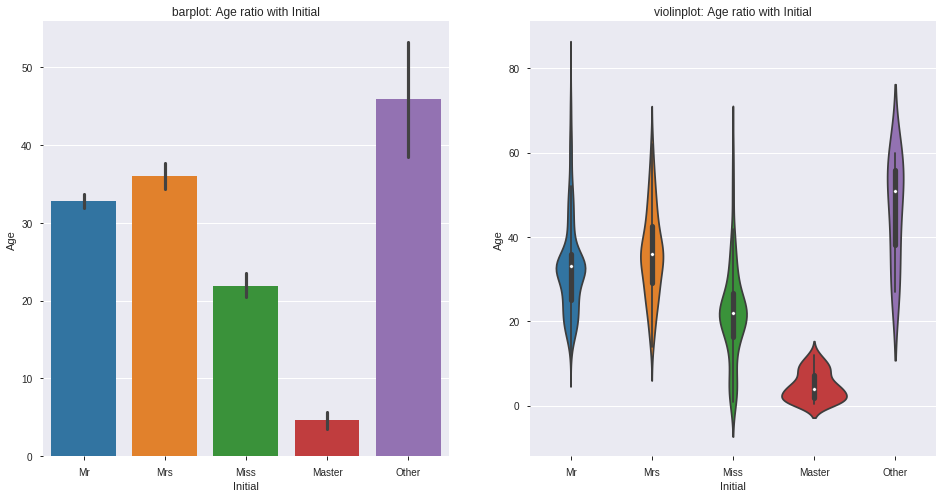

In [12]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: Age ratio with Initial')
sns.barplot(x= pdf_sdf_train['Initial'], y=pdf_sdf_train['Age'],ax=ax[0])

ax[1].set_title('violinplot: Age ratio with Initial')
sns.violinplot(pdf_sdf_train['Initial'],pdf_sdf_train['Age'], ax=ax[1])

In [13]:
# derive AgeGroup from age and sex
pdf_sdf_train['AgeGroup'] = None
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'male') & (pdf_sdf_train['Age'] <= 15)), 'AgeGroup'] = 'boy'
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'female') & (pdf_sdf_train['Age'] <= 15)), 'AgeGroup'] = 'girl'
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'male') & (pdf_sdf_train['Age'] > 15)), 'AgeGroup'] = 'adult male'
pdf_sdf_train.loc[((pdf_sdf_train['Sex'] == 'female') & (pdf_sdf_train['Age'] > 15)), 'AgeGroup'] = 'adult female'
pdf_sdf_train['AgeGroup'].value_counts()

adult male      533
adult female    271
boy              44
girl             43
Name: AgeGroup, dtype: int64

# PointPlot vs CountPlot

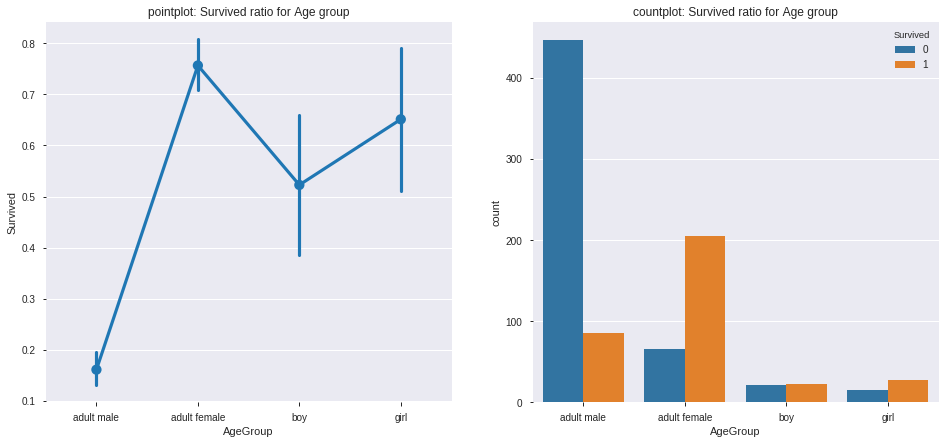

In [14]:
fig, ax = plt.subplots(1,2,figsize=(16,7))
ax[0].set_title('pointplot: Survived ratio for Age group')
sns.pointplot(pdf_sdf_train['AgeGroup'],pdf_sdf_train['Survived'],ax=ax[0])
ax[1].set_title('countplot: Survived ratio for Age group')
sns.countplot(pdf_sdf_train['AgeGroup'],hue= pdf_sdf_train['Survived'],ax=ax[1])

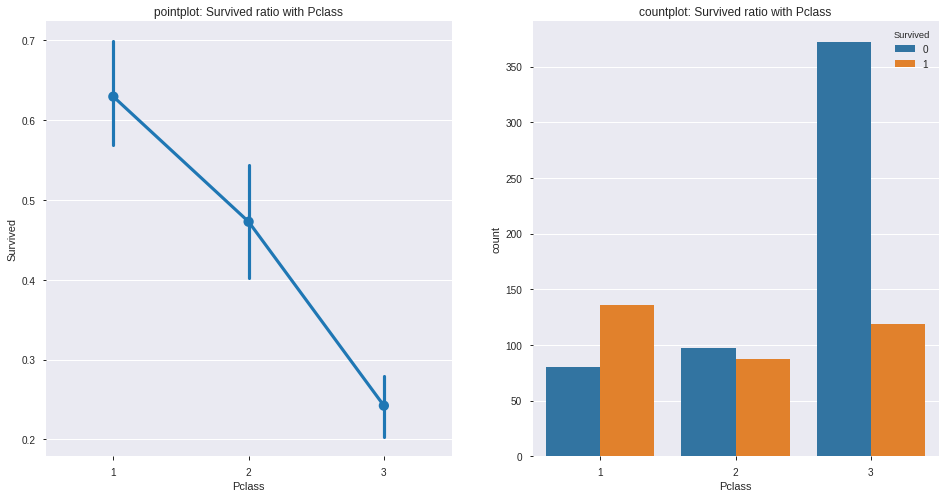

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].set_title('pointplot: Survived ratio with Pclass')
sns.pointplot(pdf_sdf_train['Pclass'],pdf_sdf_train['Survived'],ax=ax[0])
ax[1].set_title('countplot: Survived ratio with Pclass')
sns.countplot(pdf_sdf_train['Pclass'],hue= pdf_sdf_train['Survived'],ax=ax[1])

# BarPlot vs CountPlot

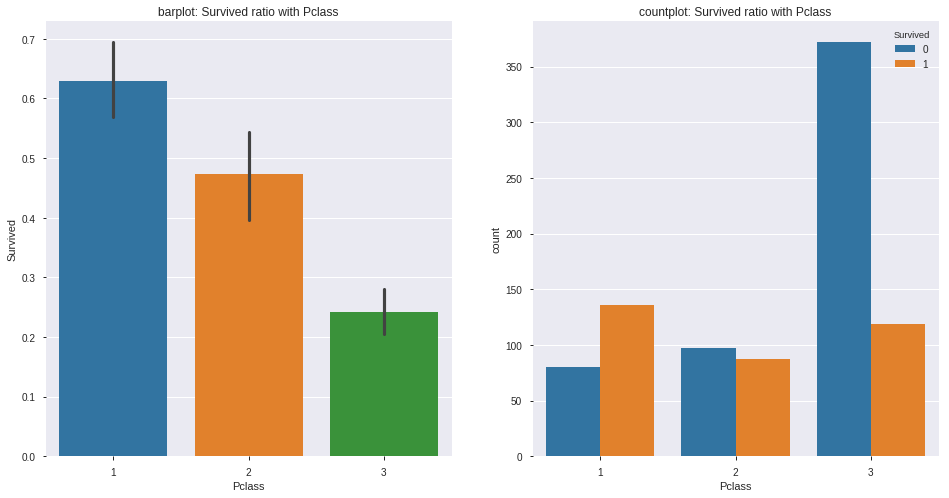

In [16]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('barplot: Survived ratio with Pclass')
sns.barplot( pdf_sdf_train['Pclass'], pdf_sdf_train['Survived'], ax=ax[0])

ax[1].set_title('countplot: Survived ratio with Pclass')
sns.countplot(x=pdf_sdf_train['Pclass'], hue=pdf_sdf_train['Survived'], ax=ax[1])

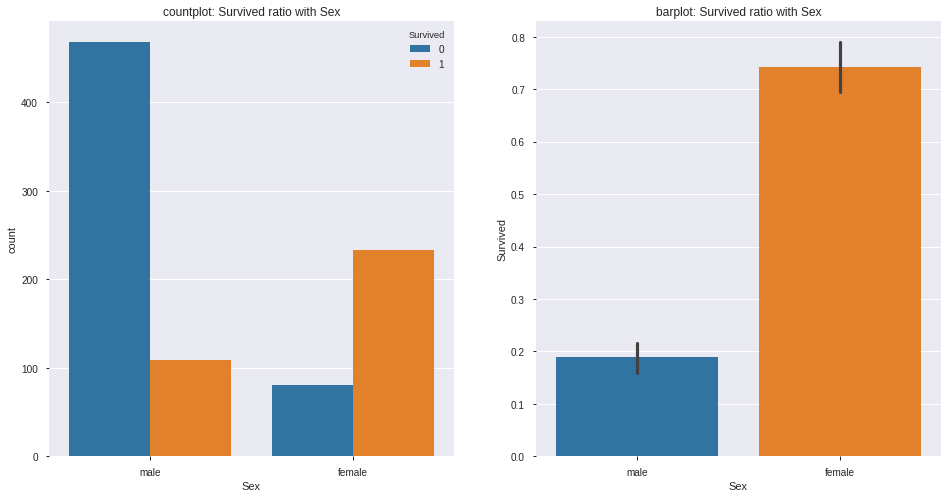

In [17]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('countplot: Survived ratio with Sex')
sns.countplot(x=pdf_sdf_train['Sex'],hue= pdf_sdf_train['Survived'],ax=ax[0])

ax[1].set_title('barplot: Survived ratio with Sex')
sns.barplot(pdf_sdf_train['Sex'], pdf_sdf_train['Survived'],ax=ax[1])


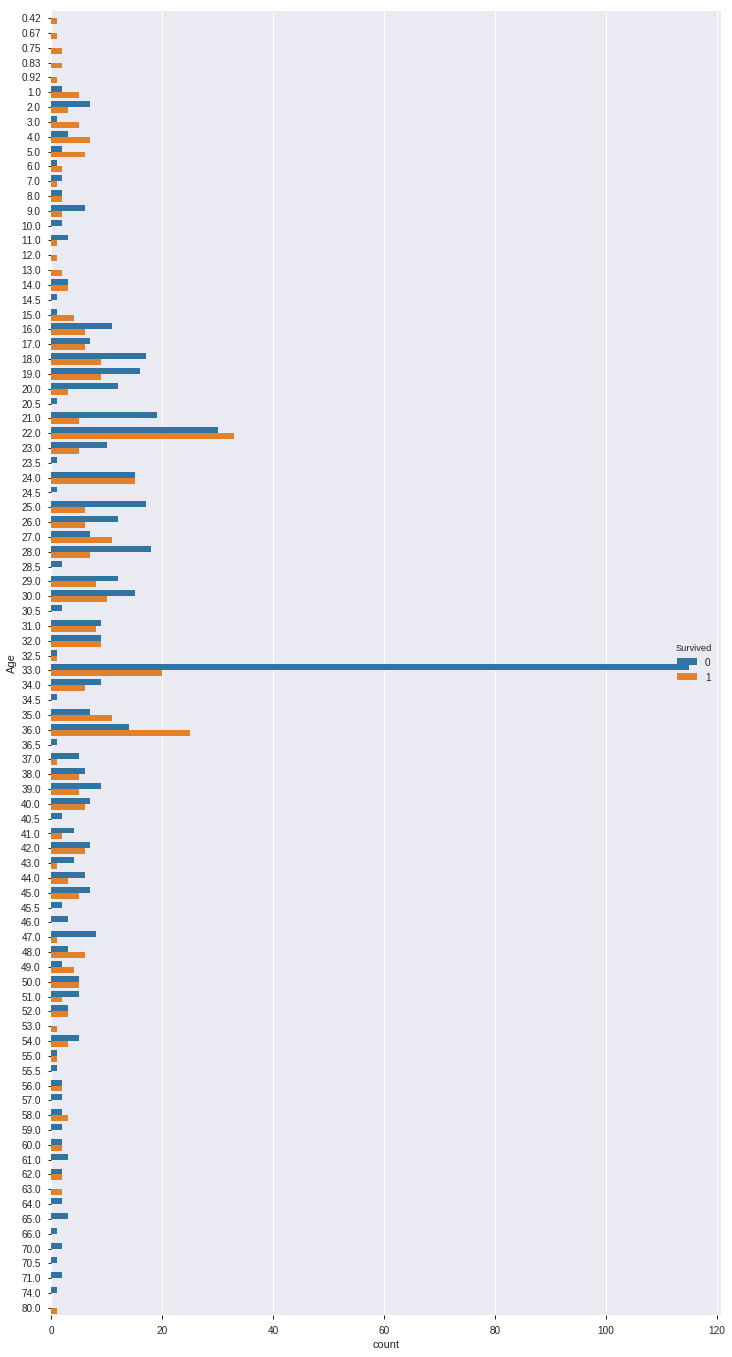

In [18]:
plt.figure(figsize=(12,24))
# plt.xticks(rotation=90)
sns.countplot(y=pdf_sdf_train['Age'],hue= pdf_sdf_train['Survived'],orient='h')

In [19]:
pd.Categorical(pdf_sdf_train['Sex'])

[male, female, female, female, male, ..., male, female, female, male, male]
Length: 891
Categories (2, object): [female, male]

16
65


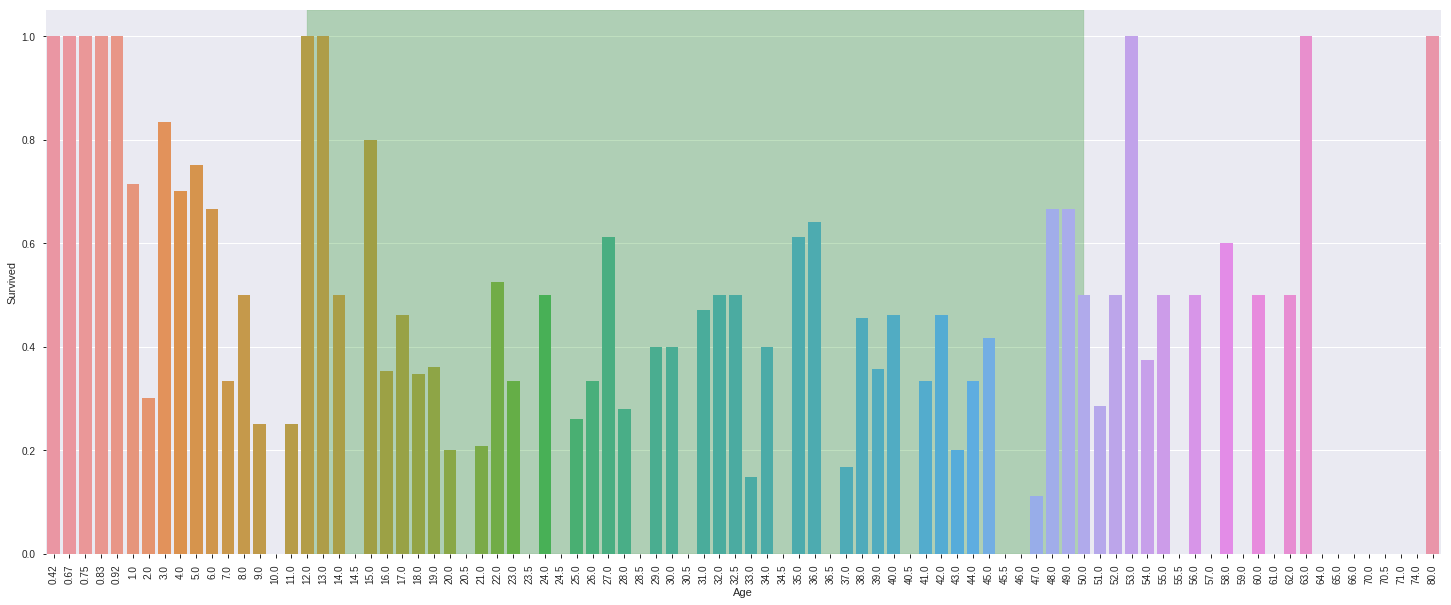

In [20]:
import numpy as np
plt.figure(figsize=(25,10))
plt.xticks(rotation=90)
plt.axvspan(np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 12]['Age'].unique())
            ,np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 50]['Age'].unique())
            ,alpha = 0.25
            , color = 'green') # without alpha = 0.25, it will be dark green!
print(np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 12]['Age'].unique()))
print(np.size(pdf_sdf_train[pdf_sdf_train['Age'] < 50]['Age'].unique()))

sns.barplot(pdf_sdf_train['Age'],pdf_sdf_train['Survived'], ci=None) # ci box plot details

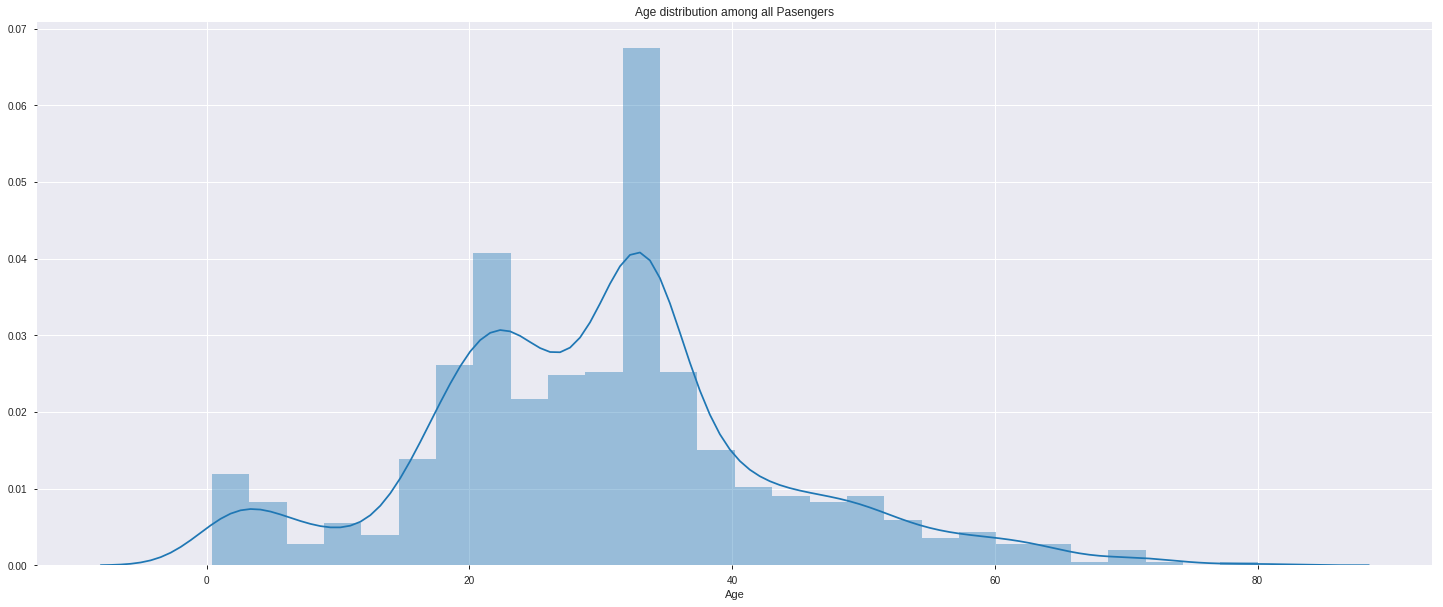

In [21]:
plt.figure(figsize=(25,10))
plt.title('Age distribution among all Pasengers')
sns.distplot(pdf_sdf_train['Age'])

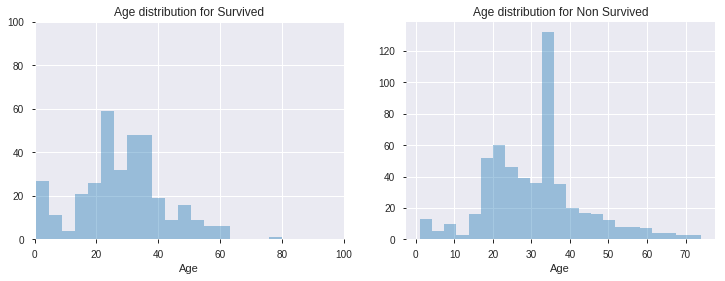

In [22]:
plt.subplot(1,2,1)
# plt.figure(figsize=(25,10))
plt.title('Age distribution for Survived')
plt.axis([0,100,0,100])
sns.distplot(pdf_sdf_train[pdf_sdf_train.Survived == 1]['Age'],kde=False)

plt.subplot(1,2,2)
plt.title('Age distribution for Non Survived')
sns.distplot(pdf_sdf_train[pdf_sdf_train.Survived == 0]['Age'],kde=False)

plt.subplots_adjust(right=1.7)
# plt.show()

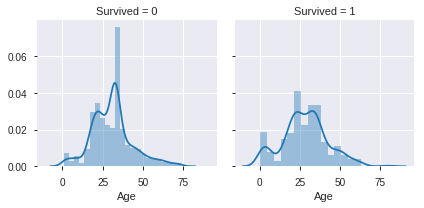

In [23]:
g = sns.FacetGrid(pdf_sdf_train,col='Survived')
g = g.map(sns.distplot,'Age')

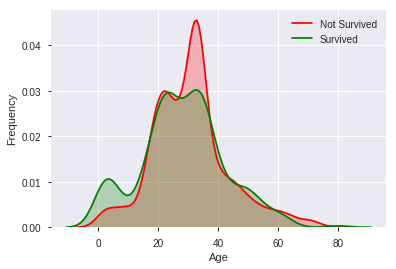

In [24]:
g = sns.kdeplot(pdf_sdf_train['Age']
                [(pdf_sdf_train['Survived']==0) 
                                     & (pdf_sdf_train['Age'].notnull())],
                color='Red',shade=True)
g = sns.kdeplot(pdf_sdf_train['Age']
                [(pdf_sdf_train['Survived']==1)  
                                     & (pdf_sdf_train['Age'].notnull())],
                color='Green',shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

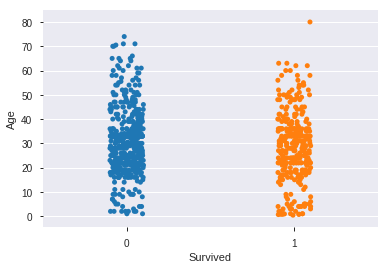

In [25]:
# https://homepage.divms.uiowa.edu/~luke/classes/STAT4580/stripplot.html
sns.stripplot(x="Survived", y="Age",data=pdf_sdf_train,jitter=True)

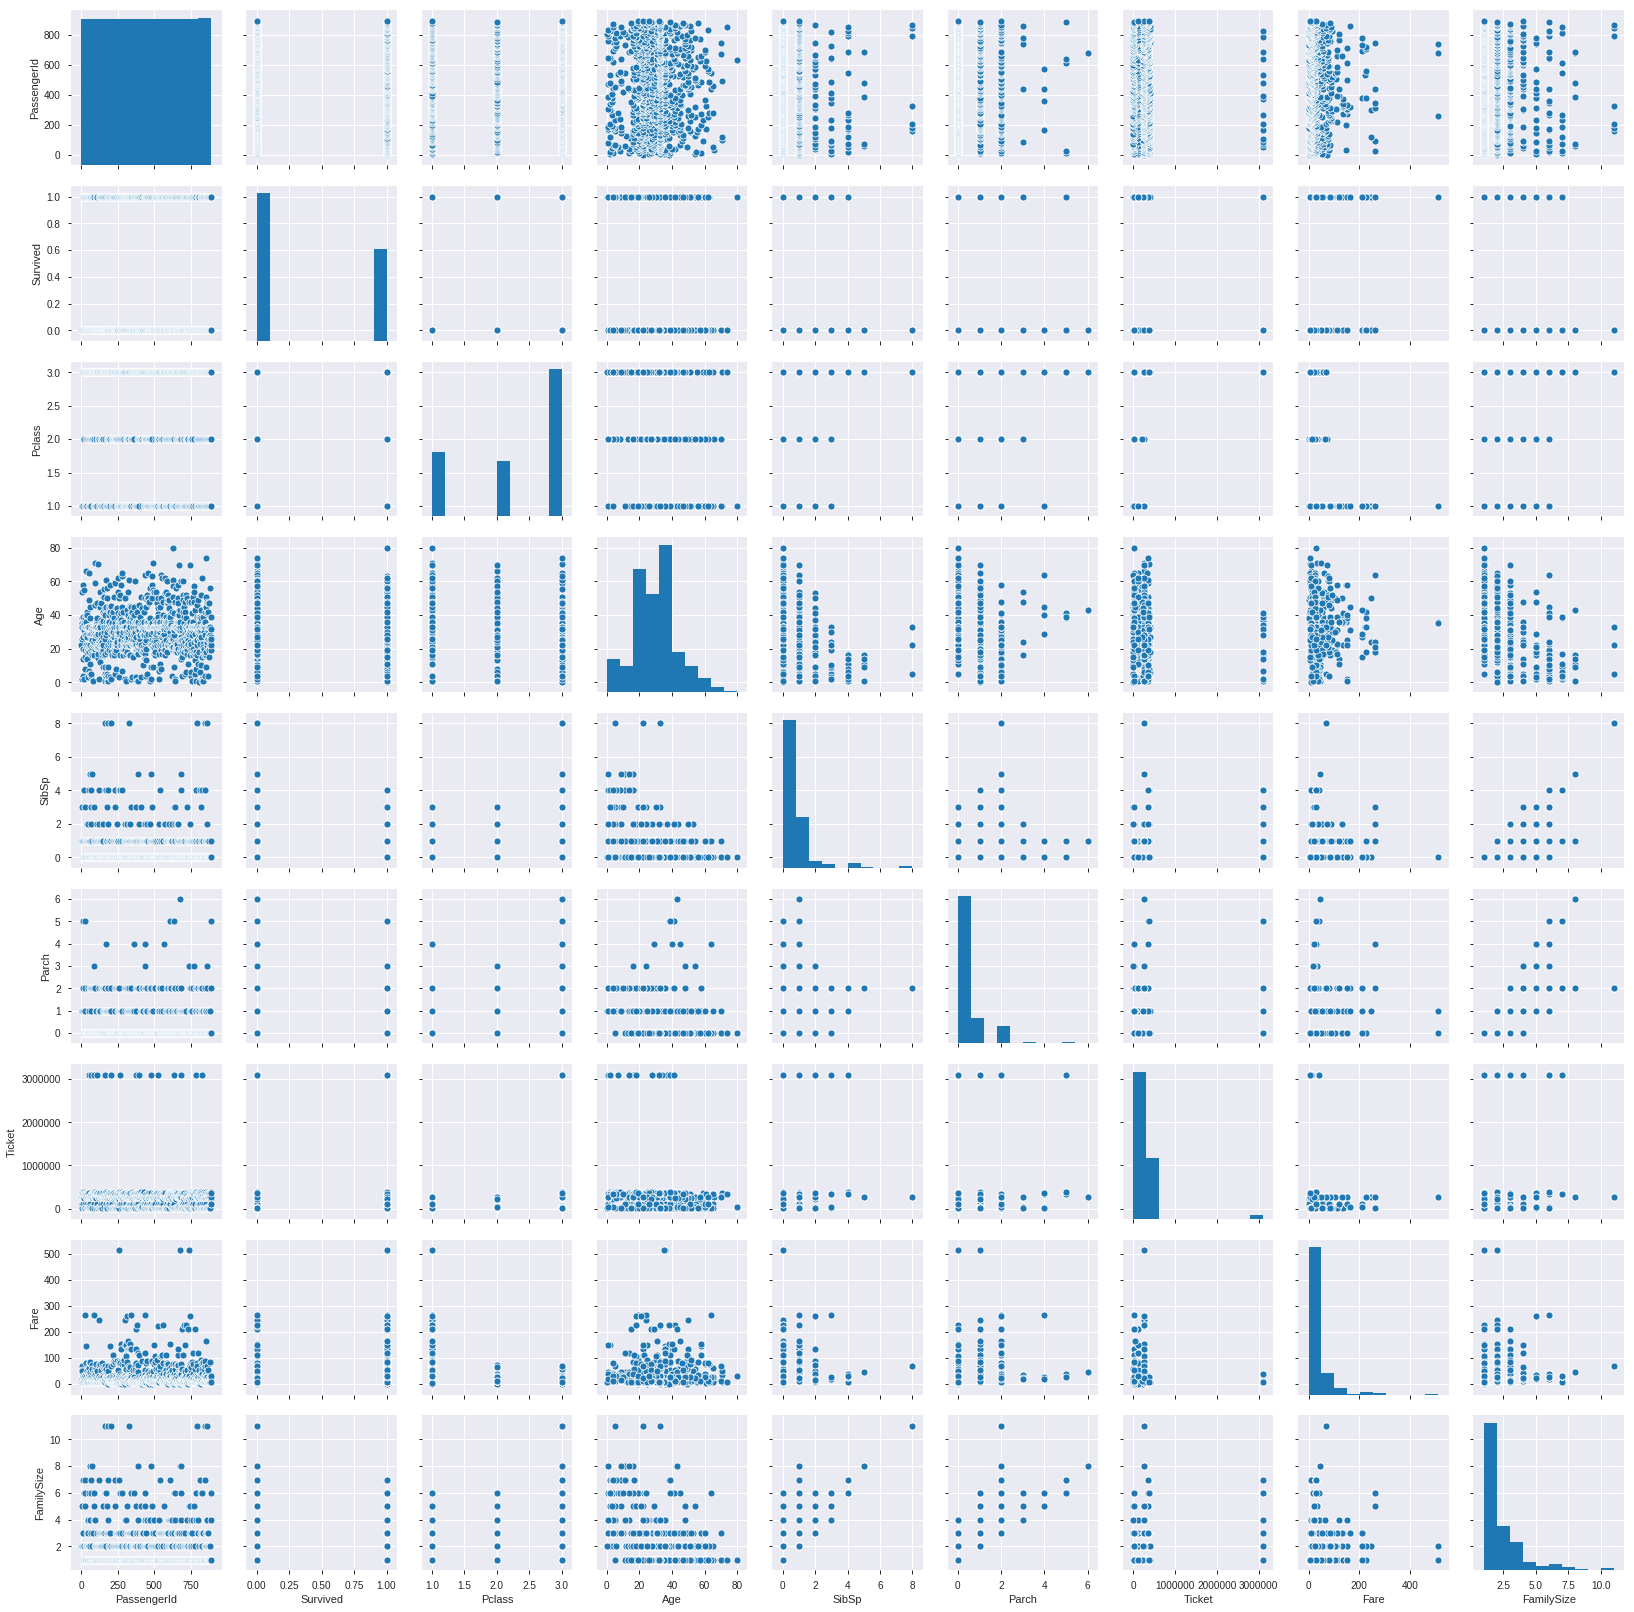

In [26]:
sns.pairplot(pdf_sdf_train)

**With pyspark.ml.feature methods :**  

In [27]:
numeric_cols = ['PassengerId','Survived', 'Pclass',
                'Age', 'SibSp','Parch','Ticket','Fare'] 
numeric_features = ['PassengerId','Pclass','Age', 'SibSp','Parch','Fare'] 
string_features = [ 'Embarked', 'Sex'] 

In [28]:
_stages = []
string_indexer =  [StringIndexer(inputCol = column , \
                                 outputCol = column + '_StringIndexer', 
                                 handleInvalid = "skip") for column in string_features]

one_hot_encoder = [OneHotEncoderEstimator(
    inputCols = [column + '_StringIndexer' for column in string_features ], \
    outputCols =  [column + '_OneHotEncoderEstimator' for column in string_features ])]

vect_indexer = [VectorIndexer(
    inputCol = column + '_OneHotEncoderEstimator',
    outputCol = column + '_VectorIndexer', 
    maxCategories=10) for column in string_features]

familt_size_splits = [1, 2, 5, 7, 100] 
bucketizer = Bucketizer(splits = familt_size_splits, 
                        inputCol = 'FamilySize',
                        outputCol = 'bucketized_FamilySize')

numeric_features += ['bucketized_FamilySize']

assemblerInput =  [f  for f in numeric_features]  
assemblerInput += [f + "_VectorIndexer" for f in string_features]
vector_assembler = VectorAssembler(inputCols = assemblerInput, \
                                   outputCol = 'VectorAssembler_features')

_stages += string_indexer
_stages += one_hot_encoder
_stages += vect_indexer
_stages += [bucketizer]
_stages += [vector_assembler]


In [29]:
_stages

[StringIndexer_93d243ebf00c,
 StringIndexer_c32f7206a760,
 OneHotEncoderEstimator_ffcf33406739,
 VectorIndexer_711b1564b15c,
 VectorIndexer_99dd73590998,
 Bucketizer_460c9b29d136,
 VectorAssembler_f773d000b75b]

In [30]:
pipeline = Pipeline(stages = _stages)

In [31]:
model = pipeline.fit(sdf_train_cleaned)

In [32]:
sdf_transformed_train = model.transform(sdf_train_cleaned)
sdf_transformed_train.limit(5).toPandas().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,260319,260319,260319,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


# ML Model

In [33]:

rf = RandomForestClassifier(labelCol = 'Survived', 
                            featuresCol = 'VectorAssembler_features', 
                            numTrees = 100, 
                            maxDepth = 4, 
                            maxBins = 1000)
_stages += [rf]

In [34]:
_stages

[StringIndexer_93d243ebf00c,
 StringIndexer_c32f7206a760,
 OneHotEncoderEstimator_ffcf33406739,
 VectorIndexer_711b1564b15c,
 VectorIndexer_99dd73590998,
 Bucketizer_460c9b29d136,
 VectorAssembler_f773d000b75b,
 RandomForestClassifier_ae941ea2374e]